# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy

# Synthetic Dataset Generation

#### Parameters (User Input)

In [3]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params()

#### True Label Generation

In [17]:
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

'''

def true_label_generation(r, eta, n):

    #np.random.seed(42)

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    effect_param = [0.5, -0.2, 0.1] # causal effect parameter (to create outcomes)

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    num_feature_mean = [0, 0, 0]
    num_feature_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    num_features = np.random.multivariate_normal(num_feature_mean, num_feature_cov, n)
    cat_features = np.random.choice(np.arange(n_cat_features), n, cat_probabilities).reshape(n,1)

    # outcomes
    outcome_continuous = 1/(1+np.exp(-np.matmul(num_features,effect_param))) # logit model + no added noise
    outcome_binary = np.where(outcome_continuous >= 0.5 , 1, 0).reshape(n,1)

    # joint = [numerical features, categorical features, & binary outcome]
    joint = np.hstack((num_features, cat_features, outcome_binary))

    # print pct of positive labels (to check threshold)
    print(round(np.mean(outcome_binary)*100, 2), "% positively labeled")



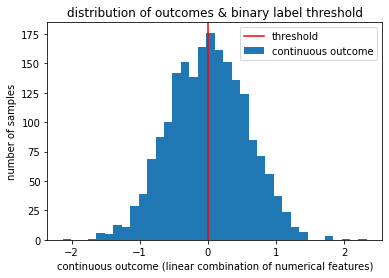

In [8]:
# visualization

threshold = 0 # binary label threshold (outcome > threshold => label=1, else 0)
# plot distribution of continuous outcomes & binary threshold 
plt.hist(np.matmul(num_features,effect_param),label='continuous outcome',bins='auto')
plt.axvline(threshold,color='red',label='threshold')
plt.xlabel("continuous outcome (linear combination of numerical features)")
plt.ylabel("number of samples")
plt.title("distribution of outcomes & binary label threshold")
plt.legend()
plt.show()

In [61]:
## add synthetic data to dataset list

# save to file
df_gaussian_synthetic_logit = pd.DataFrame(pd.DataFrame(joint))
df_gaussian_synthetic_logit.columns = ['num1','num2','num3','cat','outcome']
path_gaussian_synthetic_logit = 'Datasets/gaussian_synthetic_logit.csv'
df_gaussian_synthetic_logit.to_csv(path_gaussian_synthetic_logit)

In [59]:
df_synthetic = df_gaussian_synthetic_logit
df_synthetic['outcome'].value_counts()

0.0    118424
1.0     81576
Name: outcome, dtype: int64

# Preparation

### Data Preprocessing

In [97]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(len(df_synthetic)/2)), :]
df_test = df_synthetic.loc[range(int(len(df_synthetic)/2), len(df_synthetic)), :]

# format data
X_syn_true = df_test.iloc[:, :-1].values
y_syn_true = df_test.iloc[:, -1].values

sens_attrs_syn = [df_train['cat']]

# Bias Injection

In [91]:
df_favored_syn = df_train[df_train['cat'] == 0]
df_unfavored_syn = df_train[df_train['cat'] == 1]

In [92]:
# unfavored group with negative label
df_unfavored_syn_negative = df_unfavored_syn[df_unfavored_syn['outcome'] == 0.0]


# unfavored group with positive label (preferred)
df_unfavored_syn_positive = df_unfavored_syn[df_unfavored_syn['outcome'] == 1.0]

# differences in label counts for unfavored group
print(df_unfavored_syn['outcome'].value_counts())

df_total_syn = pd.concat([df_favored_syn, df_unfavored_syn_negative])

0.0    247
1.0    241
Name: outcome, dtype: int64


### Under-Sampling Process

In [93]:
# under-sampling process
df_undersampled_syn = df_unfavored_syn_positive.sample(n=int(len(df_unfavored_syn_positive)*0.9), random_state=42)

# combine undersampled and original favored class to create dataset
df_concat_syn = pd.concat([df_total_syn,df_undersampled_syn])

# for fairness measures later
df_sens_syn = df_concat_syn['cat']

# format data
X_syn_bias = df_concat_syn.iloc[:, :-1].values
y_syn_bias = df_concat_syn.iloc[:, -1].values

X_syn_bias_true = X_syn_bias
y_syn_bias_true = y_syn_bias

print(X_syn_true.shape, X_syn_bias_true.shape)
#print(y_true.value_counts(), "\n\n", y_bias_true.value_counts())

(1000, 4) (975, 4)


# Model

### Model Selection + Training (TODO: modularize)

In [94]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42)

# Synthetic Data
classifier_syn_true = classifier.fit(X_syn_true, y_syn_true)
y_syn_pred_truth = classifier_syn_true.predict(X_syn_true)

classifier_syn_bias = classifier.fit(X_syn_bias_true, y_syn_bias_true)
y_syn_pred_bias = classifier_syn_bias.predict(X_syn_bias_true)
y_syn_pred_bias_on_true = classifier_syn_bias.predict(X_syn_true)

### Model Performance (TODO: modularize)

In [95]:
print("Synthetic Data\n")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_syn_pred_truth, y_syn_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_syn_pred_bias, y_syn_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_syn_pred_bias_on_true, y_syn_true))

Synthetic Data

Accuracy of Ground Truth Model on Ground Truth Data:  0.986
Accuracy of Biased Model on Biased Data:  0.9825641025641025
Accuracy of Biased Model on Ground Truth Data:  0.982


In [98]:
# Ground Truth Model on Ground Truth Data

fpr_true = MetricFrame(false_positive_rate, y_syn_true, y_syn_pred_truth, sensitive_features = sens_attrs_syn[0])
print("Overall Accuracy: ", fpr_true.overall)
print("Group Accuracy : ", fpr_true.by_group)

print("\n")
fnr_true = MetricFrame(false_negative_rate, y_syn_true, y_syn_pred_truth, sensitive_features = sens_attrs_syn[0])
print("Overall Selection Rate: ", fnr_true.overall)
print("Group Selection Rate : ", fnr_true.by_group)

Overall Accuracy:  0.014285714285714285
Group Accuracy :  cat
0.0    0.0162602
1.0    0.0122951
Name: false_positive_rate, dtype: object


Overall Selection Rate:  0.013725490196078431
Group Selection Rate :  cat
0.0    0.0150376
1.0    0.0122951
Name: false_negative_rate, dtype: object


# Fairness Intervention

In [99]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
np.random.seed(0)

#### Synthetic Data

In [100]:
constraint = EqualizedOdds()
mitigator_syn_true = ExponentiatedGradient(classifier_syn_true, constraint)
mitigator_syn_true.fit(X_syn_true, y_syn_true, sensitive_features = sens_attrs_syn[0])
y_syn_pred_mitigated_true = mitigator_syn_true.predict(X_syn_true)

In [101]:
constraint = EqualizedOdds()
mitigator_syn_bias = ExponentiatedGradient(classifier_syn_bias, constraint)
mitigator_syn_bias.fit(X_syn_bias_true, y_syn_bias_true, sensitive_features = df_sens_syn)
y_syn_pred_mitigated_bias = mitigator_syn_bias.predict(X_syn_bias_true)
y_syn_pred_mitigated_bias_on_true = mitigator_syn_bias.predict(X_syn_true)

# Evaluation

In [102]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

In [103]:
print("Synthetic Data\n")

print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_syn_pred_mitigated_true, y_syn_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_syn_pred_mitigated_bias_on_true, y_syn_true))

Synthetic Data

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.986
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.982


### Bias vs Accuracy vs Fairness Trade-Off

In [125]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(classifier, X_true, y_true, df_favored,
                           df_unfavored_positive, df_unfavored_negative,
                           sensitive_feature = "cat",
                           label = "outcome", cat_cols = [],
                           apply_fairness = False, verbose = False):
    
    bias_amts = list(range(0,30))
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
    dataset_size_bias = []

    df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

    for i in range(30):
        # under-sampling process
        if i != 0:
            df_undersampled = df_undersampled.sample(n=int(len(df_undersampled)*0.9), random_state=42)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_favored, df_unfavored_negative, df_undersampled])
        df_sens = df_concat[sensitive_feature]

        # format data
        X_bias = df_concat.iloc[:, :-2].values
        y_bias = df_concat.iloc[:, -1].values

        X_bias_true = df_concat.iloc[:, :-1].values
        y_bias_true = df_concat.iloc[:, -1].values

        dataset_size_bias.append(X_bias_true.shape[0])
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        '''
        # fairness performance (TODO)
        eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
        eod_on_true.append(eod_true)

        eod_bias_on_true = equalized_odds_difference(y_true=y_true,\
        y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
        eod_on_biased.append(eod_bias_on_true)

        # table visualization 
        table_elem = [i*10, acc_bias, acc_bias_on_true]
        table.append(table_elem)
        '''
        
        if verbose:
            print("Finished Iteration: ", i)

    return bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased,\
           accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [126]:
def accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        #plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        #plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()

In [127]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                        dataset_size_true, dataset_size_bias):
    plt.figure(figsize=(17,7))

    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend(loc = 3)

    plt.subplot(1,2,2)
    plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
    plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
    plt.xlabel("Number of iterations of removing 10% of positively labeled minority samples")
    plt.ylabel("Dataset Size")
    plt.title("Amount of Minority Samples Removed vs Dataset Size")
    plt.legend()

    plt.show()

In [128]:
classifier = LogisticRegression()

bias_amts, dataset_size_true, dataset_size_bias, \
accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(classifier, X_true=X_syn_true, y_true=y_syn_true, \
                       df_favored=df_favored_syn, df_unfavored_positive= df_unfavored_syn_positive,\
                       df_unfavored_negative= df_unfavored_syn_negative, sensitive_feature="cat",
                       cat_cols=[3], label = "outcome",
                       apply_fairness=True,verbose=True)

Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Iteration:  11
Finished Iteration:  12
Finished Iteration:  13
Finished Iteration:  14
Finished Iteration:  15
Finished Iteration:  16
Finished Iteration:  17
Finished Iteration:  18
Finished Iteration:  19
Finished Iteration:  20
Finished Iteration:  21
Finished Iteration:  22
Finished Iteration:  23
Finished Iteration:  24
Finished Iteration:  25
Finished Iteration:  26
Finished Iteration:  27
Finished Iteration:  28
Finished Iteration:  29


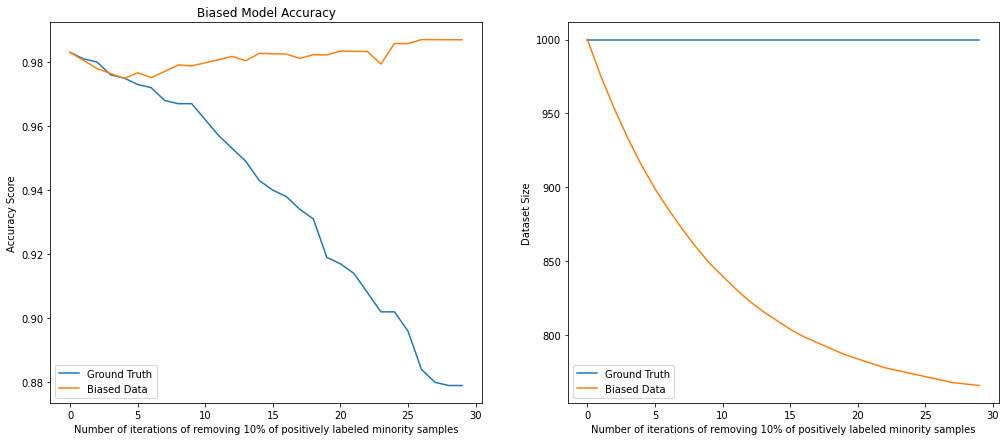

In [129]:
# without fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

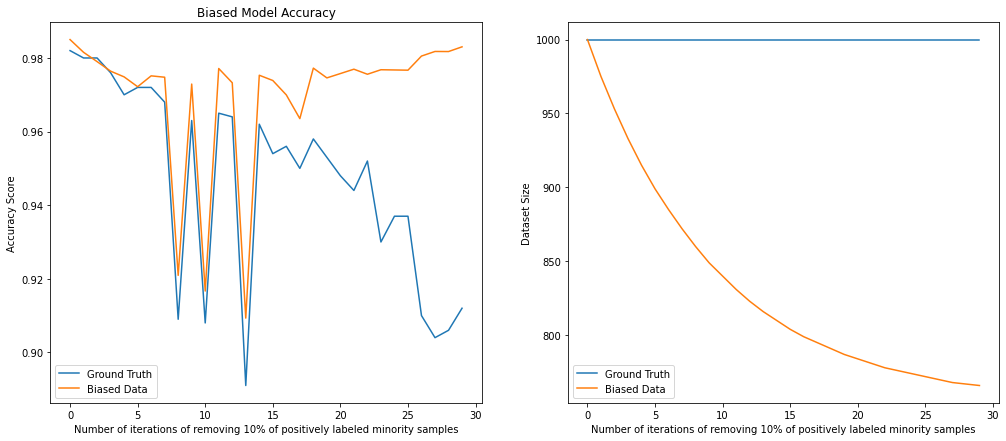

In [130]:
# with fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True)

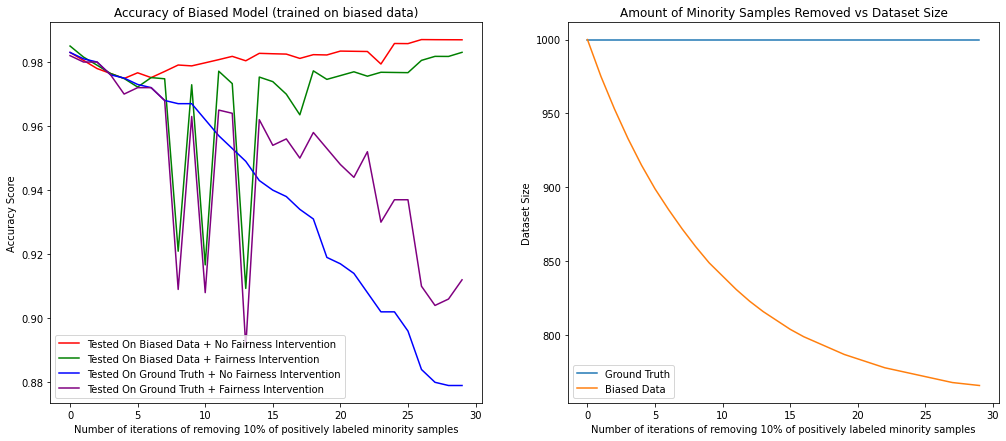

In [131]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                    accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                    dataset_size_true, dataset_size_bias)